# Dynamics of a Heated Tank with PI Temperature Control
This is the tenth problem of the famous set of [Ten Problems in Chemical Engineering](https://www.polymath-software.com/ASEE/Tenprobs.pdf).  Here, the goal is to solve ordinary differential equations, generation of step functions, simulation of a proportional integral (PI) controller.

Jacob Albrecht, 2019

# Problem Setup

A continuously stirred tank with internal temperature $T$ has a PI controller with a temperature set point.  The PI controller has a set temperature $T_r$ and a temperature measurement $T_m$ of the tank outflow with true outlet temperature $T_o$. Fluid flows into the tank at temperature $T_i$ and mass flow rate $W$, with density $\rho$ and heat capacity $C_P$.  The controller is influenced by the measurement dead time $\tau_d$, the integral time constant $\tau_i$, the thermocouple time constant $\tau_m$, and the controller gain $K_c$.  The governing equations are:

$$\frac{dT}{dt}=\frac{WC_p\left(T_i-T\right)+q}{\rho VC_p}$$

$$q_s = WC_p\left(T_r-T_i\right)$$

$$\frac{dT_m}{dt} = \frac{T_o-T_m}{\tau_m}$$

$$\frac{dErr}{dt} = T_r-T_m$$

$$q = q_s+K_c\left(T_r-T_m\right)+\frac{K_c}{\tau_i}Err$$

The effect of dead time in the outlet is modeled using the Padé approximation:
$$\frac{dT_o}{dt} = \left(T-T_o-\frac{\tau_d}{2}\frac{dT}{dt}\right)\frac{2}{\tau_d}$$


# Problem Tasks

a) Demonstrate the open loop performance (set $K_c$ = 0) of this system when the system is initially operating at design steady state at a temperature of 80°C, and inlet temperature $T_i$ is suddenly changed to 40°C at time t = 10 min. Plot the temperatures $T$, $T_o$, and $T_m$ to steady state,and  verify  that  Padé  approximation  for  1  min  of  dead  time is  working properly.

b) Demonstrate the closed loop performance of the system for the conditions of part a). Plot temperatures $T$, $T_o$, and $T_m$ to steady state.

c) Repeat part b) with $K_c$ = 500 kJ/min⋅°C.

d) Repeat part c) for proportional only control action by setting the term $K_c$/$\tau_i$ = 0.

e) Implement limits on $q$ so that the maximum is 2.6 times the baseline steady  state  value  and  the  minimum  is  zero.  Demonstrate  the  system  response  from  baseline steady state for a proportional only controller when the set point is changed from 80°C to 90°C at $t$ = 10 min. $K_c$ = 5000 kJ/min⋅°C. Plot $q$ and $qlim$ versus time to steady state to demonstrate the limits. Also plot the temperatures $T$, $T_o$, and $T_m$ to steady state to indicate controller performance 

# Solutions
First define the equations and constants for parts a-d:

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def picontrol(t,Y):
    T,To,Tm,Err=Y # unpack
    if t<10:
        T_i = 60
    else:
        T_i = 40
    
    q= q_s+K_c*(T_r-Tm)+K_c/tau_i*Err
    dTdt= (WCp*(T_i-T)+q)/(rhoVCp);
    dTodt = (T-To- tau_d/2*dTdt)*2/tau_d;
    dTmdt = (To-Tm)/tau_m;
    dErrdt = T_r - Tm;
    return([dTdt,dTodt,dTmdt,dErrdt])

qsetpt= 1e4
tau_d=1
tau_i=2
tau_m = 5
T_r=80
T_is = 60
rhoVCp = 4000
WCp = 500
q_s = WCp*(T_r-T_is)


T0=[80, 80, 80, 0]

## solution to part a)
for an open loop, set $K_c$ to zero, solve the ODEs and plot the tank and outlet temperature, with a lag of $\tau_d$ to check the Padé approximation.  Use the `LSODA` implicit solver.  Use the dead time $\tau_d$ for the sampling period:

In [3]:
K_c = 0
t0=0
tfin=60
tspan = [t0, tfin]
t_eval = np.arange(tspan[0],tspan[1],tau_d)
sol = solve_ivp(picontrol,tspan,T0,t_eval=t_eval,method='LSODA')

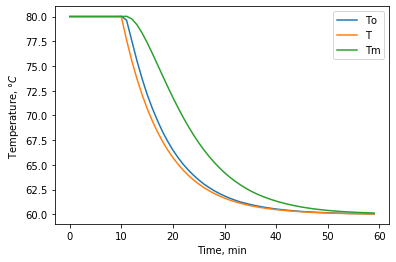

In [4]:
t = sol.t
T,To,Tm,Err=sol.y
plt.plot(t,To,label='To')
plt.plot(t,T,label='T')
plt.plot(t,Tm,label='Tm')
plt.xlabel('Time, min')
plt.ylabel('Temperature, $\degree C$')
plt.legend();

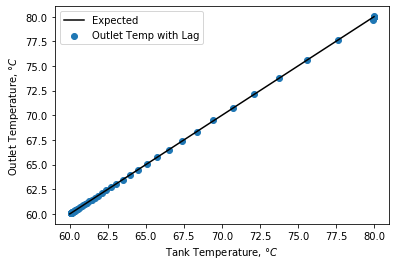

In [5]:
plt.scatter(T[:-tau_d],To[tau_d:],label='Outlet Temp with Lag')
plt.plot([60,80],[60,80],'k',label='Expected')
plt.xlabel('Tank Temperature, $\degree C$')
plt.ylabel('Outlet Temperature, $\degree C$')
plt.legend();

Given the good aggreement, it appears that the Padé approximation for the delay is appropriate.  The values of $T(t)$ and $T_o(t)$ are offset by $\tau_d$

## solution to part b)

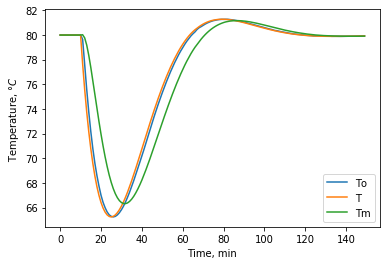

In [6]:
K_c = 50 # closed loop
tfin=150
tspan = [t0, tfin]
t_eval = np.arange(tspan[0],tspan[1],tau_d)
sol = solve_ivp(picontrol,tspan,T0,t_eval=t_eval,method='LSODA')
t = sol.t
T,To,Tm,Err=sol.y
plt.plot(t,To,label='To')
plt.plot(t,T,label='T')
plt.plot(t,Tm,label='Tm')
plt.xlabel('Time, min')
plt.ylabel('Temperature, $\degree C$')
plt.legend();

## solution to part c)

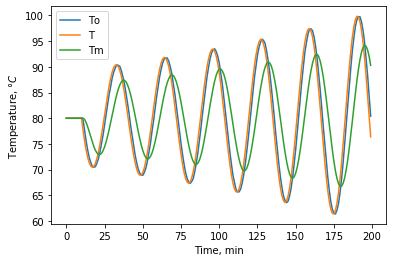

In [7]:
K_c = 500
tfin=200
tspan = [t0, tfin]
t_eval = np.arange(tspan[0],tspan[1],tau_d)
sol = solve_ivp(picontrol,tspan,T0,t_eval=t_eval)
t = sol.t
T,To,Tm,Err=sol.y
plt.plot(t,To,label='To')
plt.plot(t,T,label='T')
plt.plot(t,Tm,label='Tm')
plt.xlabel('Time, min')
plt.ylabel('Temperature, $\degree C$')
plt.legend();

## solution to part d)

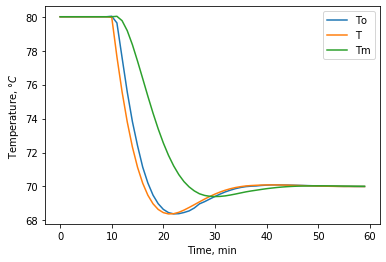

In [8]:
K_c = 500
tau_i = np.inf  # setting tau_i to +infinity effectively disables integral control
tfin=60
tspan = [t0, tfin]
t_eval = np.arange(tspan[0],tspan[1],tau_d)
sol = solve_ivp(picontrol,tspan,T0,t_eval=t_eval,method='LSODA')
t = sol.t
T,To,Tm,Err=sol.y
plt.plot(t,To,label='To')
plt.plot(t,T,label='T')
plt.plot(t,Tm,label='Tm')
plt.xlabel('Time, min')
plt.ylabel('Temperature, $\degree C$')
plt.legend();

## solution to part e)
Redefine the function to include constraints on the heater

In [9]:
def picontrol_e(t,Y):
    T,To,Tm,Err=Y # unpack
    if t<10:
        T_r = 80
    else:
        T_r = 90;
    q = q_s+K_c*(T_r-Tm)+K_c/tau_i*Err
    qlim= np.clip(q,qmin,qmax)  # clip does what you expect: keeps values between min and max
    
    dTdt= (WCp*(T_i-T)+qlim)/(rhoVCp);
    dTodt = (T-To- tau_d/2*dTdt)*2/tau_d;
    dTmdt = (To-Tm)/tau_m;
    dErrdt = T_r - Tm;
    return([dTdt,dTodt,dTmdt,dErrdt])

K_c = 5000
T_i = 60
tau_i = np.inf  # setting tau_i to infinity effectively disables integral control
tfin=200
tspan = [t0, tfin]
t_eval = np.arange(tspan[0],tspan[1],tau_d)
qmin = 0
qmax = 2.6*q_s

sol = solve_ivp(picontrol_e,tspan,T0,t_eval=t_eval,method='LSODA')

Unpack results and recalculate the values for plotting:

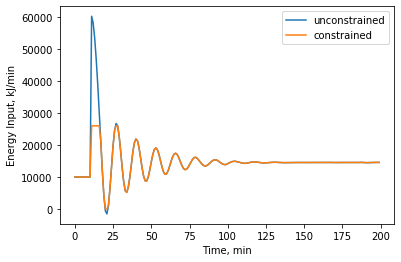

In [10]:
t = sol.t
T,To,Tm,Err=sol.y
T_r  = np.ones(t.shape)*80+(t>10)*10 # one way to redefine T_r according to the problem statement
q =  q_s+K_c*(T_r-Tm)+K_c/tau_i*Err
qlim= np.clip(q,qmin,qmax) 

plt.plot(t,q,label='unconstrained')
plt.plot(t,qlim,label = 'constrained')
plt.xlabel('Time, min')
plt.ylabel('Energy Input, kJ/min')
plt.legend();

The constraints do affect the oscillations of the controller.  Plot the profiles of $T_o$, $T$, and $T_m$ over time:

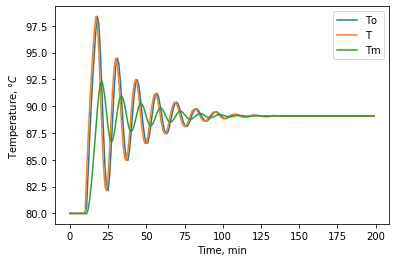

In [11]:
plt.plot(t,To,label='To')
plt.plot(t,T,label='T')
plt.plot(t,Tm,label='Tm')
plt.xlabel('Time, min')
plt.ylabel('Temperature, $\degree C$')
plt.legend();

# Reference
“The Use of Mathematical Software packages in Chemical Engineering”, Michael B. Cutlip, John J. Hwalek, Eric H.
Nuttal, Mordechai Shacham, Workshop Material from Session 12, Chemical Engineering Summer School, Snowbird,
Utah, Aug., 1997.

In [12]:
%load_ext watermark
%watermark -v -p scipy,matplotlib,numpy

CPython 3.7.3
IPython 7.6.1

scipy 1.3.0
matplotlib 3.1.0
numpy 1.16.4
